In [9]:
import numpy as np

from time import time

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

import rustworkx as rx

from qiskit_nature.problems.second_quantization.lattice import Lattice

# Custom Heisenberg couplings
import sys
sys.path.append(r'.')  # may be needed if running notebook on a cloud service
from heisenberg_model import HeisenbergModel
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

from qiskit.quantum_info import SparsePauliOp
from qiskit.algorithms import NumPyEigensolver
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp

from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Options
from qiskit.algorithms.minimum_eigensolvers import VQE

In [10]:
import pstring as ps
import grouping
import tableau as tabl
import tableau_operations as tab_op
import diagonalize as dg
import load_data
import algorithm

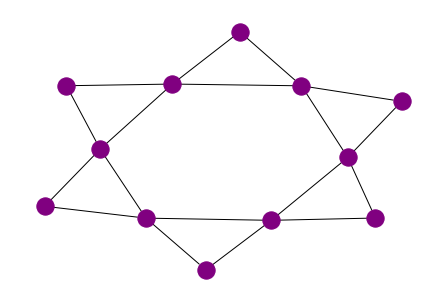

In [11]:
# Kagome unit cell
num_sites = 12
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 3, t),
    (3, 4, t),
    (4, 5, t),
    (5, 0, t),
    (0, 6, t),
    (1, 6, t),
    (1, 7, t),
    (2, 7, t),
    (2, 8, t),
    (3, 8, t),
    (3, 9, t),
    (4, 9, t),
    (4, 10, t),
    (5, 10, t),
    (5, 11, t),
    (0, 11, t),
]
# Generate graph from the list of edges
graph.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell = Lattice(graph)

# Draw Lattice
kagome_unit_cell.draw(style={'node_color':'purple'})
# plt.savefig('kagome_unit_cell.png')
plt.show()

In [12]:
# Build Hamiltonian from graph edges
heis = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell,
    uniform_interaction=1.0,  # same spin-spin interaction weight as used in graph
    uniform_onsite_potential=0.0,  # No singe site external field
)

# The Lattice needs an explicit mapping to the qubit states.
# We map 1 qubit for 1 spin-1/2 particle using the LogarithmicMapper
log_mapper = LogarithmicMapper()
# Multiply by factor of 4 to account for (1/2)^2 terms from spin operators in the HeisenbergModel
ham = 4 * log_mapper.map(heis.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect.
# There are 18 edges and 3 terms per edge (XX, YY, and ZZ),
# so there should be 54 equally weighted terms.
ham

PauliSumOp(SparsePauliOp(['ZIIIIIZIIIII', 'IZIIIIZIIIII', 'IZIIIIIZIIII', 'IIZIIIIZIIII', 'IIIIIIZZIIII', 'IIZIIIIIZIII', 'IIIZIIIIZIII', 'IIIIIIIZZIII', 'IIIZIIIIIZII', 'IIIIZIIIIZII', 'IIIIIIIIZZII', 'IIIIZIIIIIZI', 'IIIIIZIIIIZI', 'IIIIIIIIIZZI', 'ZIIIIIIIIIIZ', 'IIIIIZIIIIIZ', 'IIIIIIZIIIIZ', 'IIIIIIIIIIZZ', 'YIIIIIYIIIII', 'IYIIIIYIIIII', 'IYIIIIIYIIII', 'IIYIIIIYIIII', 'IIIIIIYYIIII', 'IIYIIIIIYIII', 'IIIYIIIIYIII', 'IIIIIIIYYIII', 'IIIYIIIIIYII', 'IIIIYIIIIYII', 'IIIIIIIIYYII', 'IIIIYIIIIIYI', 'IIIIIYIIIIYI', 'IIIIIIIIIYYI', 'YIIIIIIIIIIY', 'IIIIIYIIIIIY', 'IIIIIIYIIIIY', 'IIIIIIIIIIYY', 'XIIIIIXIIIII', 'IXIIIIXIIIII', 'IXIIIIIXIIII', 'IIXIIIIXIIII', 'IIIIIIXXIIII', 'IIXIIIIIXIII', 'IIIXIIIIXIII', 'IIIIIIIXXIII', 'IIIXIIIIIXII', 'IIIIXIIIIXII', 'IIIIIIIIXXII', 'IIIIXIIIIIXI', 'IIIIIXIIIIXI', 'IIIIIIIIIXXI', 'XIIIIIIIIIIX', 'IIIIIXIIIIIX', 'IIIIIIXIIIIX', 'IIIIIIIIIIXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j

In [80]:
# get the hamiltonian in my pstrings implementation
# helper function
to_num_map = {"I":0, "X":1, "Y":2, "Z":3}
def to_numerical(pauli_string):
    
    return ''.join([str(to_num_map[p]) for p in pauli_string])
# Get the Pauli operators 
ham_strings = [ps.pstring(to_numerical(term.to_pauli_op().primitive.to_label()), term.coeff) for term in ham]
def diagonalize_cluster(cluster):
    
    # diagonalize
    x,z,s,u = dg.main_diagonalizer(cluster)
    
    return x,z,s,u
diagonalizations = {c:diagonalize_cluster(clusters[c]) for c in range(3)}
clusters = grouping.make_clusters(ham_strings)
gs2 = "111101100110"

In [120]:
def make_circuit_layer(cl, l):

    qc = QuantumCircuit(12)
    cluster = clusters[cl]
    _,Z,S,U = diagonalizations[cl]
    Z = np.array(Z)
    S = np.array(S)

    qc = qc.compose(U)

    for p in range(len(Z)):
        pauli = Z[p]
        s = S[p]
        pivots = []
        param = Parameter(f"Theta{cl, l,p}")
        for c in range(len(pauli)):

            if pauli[c] == 1:
                pivots.append(c)
        
        if len(pivots) != 2:
            print("oups")
        qc.cx(pivots[0], pivots[1])

        qc.rz(2 * (-1)**s * param, pivots[1])

        qc.cx(pivots[0], pivots[1])
    
    qc = qc.compose(U.inverse())

    return qc

def make_layers(L):
    qc = QuantumCircuit(12)
    for l in range(L):
        tmp = QuantumCircuit(12)
        tmp = tmp.compose(make_circuit_layer(0,l))
        tmp = tmp.compose(make_circuit_layer(2,l))
        tmp = tmp.compose(make_circuit_layer(1,l))

        qc = qc.compose(tmp)
    
    return qc

In [161]:
def build_ansatz(L):

    ansatz = make_circuit_layer(2,-1)
    for c in range(len(gs2)):
        
        if gs2[c] == "1":
            ansatz.x(c)
        
        # try:
        #     ansatz.cx(c,c+1)
        # except:
        #     pass
    
    qc = make_layers(L)
    ansatz = qc.compose(ansatz)

    return ansatz

In [162]:
# simulate
service = QiskitRuntimeService()

backend = "ibmq_qasm_simulator"

In [163]:
# Use RealAmplitudes circuit to create trial states
from qiskit.circuit.library import RealAmplitudes

#ansatz = RealAmplitudes(num_qubits=2, reps=2)

# Search for better states using SPSA algorithm
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(1)


np.random.seed(6)
#initial_point = np.random.uniform(-np.pi, np.pi, 3*1)

# Create an object to store intermediate results
from dataclasses import dataclass

In [164]:
@dataclass
class VQELog:
    values: list
    parameters: list

    def update(self, count, parameters, mean, _metadata):
        self.values.append(mean)
        self.parameters.append(parameters)
        print(f"Running circuit {count} of ~350", end="\r", flush=True)


log = VQELog([], [])

In [165]:
# Main calculation
L = 2
initial_point = np.random.uniform(-np.pi, np.pi, 3*18*L + 18)
ansatz = build_ansatz(L)
hamiltonian = ham

optimizer = SPSA(150)

with Session(service=service, backend=backend) as session:
    options = Options()
    options.optimization_level = 1

    vqe = VQE(
        Estimator(session=session, options=options),
        ansatz,
        optimizer,
        callback=log.update,
        initial_point=initial_point,
    )
    result = vqe.compute_minimum_eigenvalue(ham)
    print("Experiment complete.".ljust(30))
    print(f"Raw result: {result.optimal_value}")

    if "simulator" not in backend:
        # Run once with ZNE error mitigation
        options.resilience_level = 1
        vqe = VQE(
            Estimator(session=session, options=options),
            ansatz,
            SPSA(150),
            initial_point=result.optimal_point,
        )
        result = vqe.compute_minimum_eigenvalue(hamiltonian)
        print(f"Mitigated result: {result.optimal_value}")

Experiment complete.          
Raw result: -0.886
